In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
from datetime import date
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")

# xgboost
from xgboost import XGBRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from pickle import dump, load

In [2]:
start = dt.datetime(2022,3,9)
end = dt.datetime(2022,4,25)

# Extract Crypto Price

In [3]:
#read crypto pricing
#extract data from yahoo finance
GST = web.DataReader('GST2-USD','yahoo', start, end)
GMT = web.DataReader('GMT3-USD','yahoo', start, end)

In [4]:
GST = GST.reset_index()
GMT = GMT.reset_index()

In [5]:
def convert_date(data):
    data.date = pd.to_datetime(data.date)
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    #data.columns = data.columns.str.replace('Date', 'date')
    return data

In [6]:
GST.columns = GST.columns.str.replace('Date', 'date')
GMT.columns = GMT.columns.str.replace('Date', 'date')

GST = convert_date(GST)
GMT = convert_date(GMT)


In [7]:
#add pct change column to capture daily crypto price change
ClosingPrice = GST[['Adj Close']]
GST['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = GMT[['Adj Close']]
GMT['pct_change'] = ClosingPrice.pct_change()*100

GST = GST.set_index('date')
GMT = GMT.set_index('date')


# Load sentiment score for crypto news and stock market new

In [8]:
news = pd.read_csv(r"Data/News_sentiment.csv", sep="\t")

In [9]:
def filter_news_sentiment(start, end, data):
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    crypto_news = data[(data['category'] == 'Cryptocurrencies')].reset_index()
    stocks_market_news = data[(data['category'] == 'Stock Market')].reset_index()
    finance_news = data[(data['category'] == 'Finance')].reset_index()
    #metaverse_news = data[(data['category'] == 'Metaverse')].reset_index()
    
    crypto_news = split_news_category(crypto_news)
    stocks_market_news = split_news_category(stocks_market_news)
    finance_news = split_news_category(finance_news)
    #metaverse_news = split_news_category(metaverse_news, remove_pos_bias, remove_neg_bias)
    
    return crypto_news,stocks_market_news,finance_news

In [10]:
def split_news_category(data):
    #group daily sentiment score
    data = data.drop(['content'], axis=1)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    data = data.sort_index() # sort by datetime
    data = data.reset_index()
    
    data = data.set_index('date')
    
    data["sentiment_score_1"] = data.shift(1)
    return data

In [11]:
start_sentiment = dt.datetime(2022,3,9)
end_sentiment = dt.datetime(2022,4,25)


In [12]:
crypto_news, stocks_market_news, finance_news = filter_news_sentiment(start_sentiment, end_sentiment, news)

#remove all the sentiment score left only between -0.5 above or more than 0.5
positive = 0.5
negative = -0.5

crypto_news_filter = crypto_news[(crypto_news['sentiment_score'] > positive) | (crypto_news['sentiment_score'] < negative)]
stocks_market_news_filter = stocks_market_news[(stocks_market_news['sentiment_score'] > positive) | (stocks_market_news['sentiment_score'] < negative)]


# Generated RSI

In [13]:
# Calculate the RSI via pandas_ta
GST_7_RSI = GST.ta.rsi(close='Adj Close', length=7, append=True,signal_indicators=True)
GST_14_RSI = GST.ta.rsi(close='Adj Close', length=14, append=True,signal_indicators=True)

In [14]:
def pandas_rsi(df: pd.DataFrame, window_length: int = 14, output: str = None, price: str = 'adj close'):
    """
    An implementation of Wells Wilder's RSI calculation as outlined in
    his 1978 book "New Concepts in Technical Trading Systems" which makes
    use of the α-1 Wilder Smoothing Method of calculating the average
    gains and losses across trading periods and the Pandas library.
    @author: https://github.com/alphazwest
    Args:
        df: pandas.DataFrame - a Pandas Dataframe object
        window_length: int - the period over which the RSI is calculated. Default is 14
        output: str or None - optional output path to save data as CSV
        price: str - the column name from which the RSI values are calcuated. Default is 'Close'
    Returns:
        DataFrame object with columns as such, where xxx denotes an inconsequential
        name of the provided first column:
            ['xxx', 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi']
    """
    # Calculate Price Differences using the column specified as price.
    df['diff'] = df['adj close'].diff(1)

    # Calculate Avg. Gains/Losses
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)

    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Calculate Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length

    # Calculate Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length

    # Calculate RS Values
    df['rs'] = df['avg_gain'] / df['avg_loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))

    # Save if specified
    if output is not None:
        df.to_csv(output)

    return 

In [15]:
GST.columns = map(str.lower, GST.columns)
# Make RSI Calculations
pandas_rsi(df=GST, window_length=14, price='adj close')

GMT.columns = map(str.lower, GMT.columns)
# Make RSI Calculations
pandas_rsi(df=GMT, window_length=14, price='adj close')


# XGBoost prediction model

In [16]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [17]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [18]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    #dump(model,open('Models/predictive/{0}_model.pkl'.format(crypto),'wb'))
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 

In [19]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# GST

In [25]:
def plot_prediction_result(values, var):
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=var)
    # evaluate
    mae, y, yhat = walk_forward_validation(data, 40)
    print('MAE: %.3f' % mae)
    # plot expected vs preducted
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
    pyplot.legend()
    pyplot.show()

MAE: 0.319


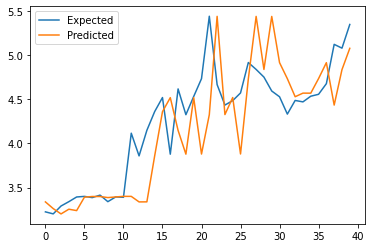

In [26]:
values=GST[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [27]:
gst_merge_data = pd.DataFrame({ 
                            'open': GST['open'],
                            'rsi': GST['rsi'],
                            'rs': GST['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': GST['adj close']
                          })

MAE: 0.229


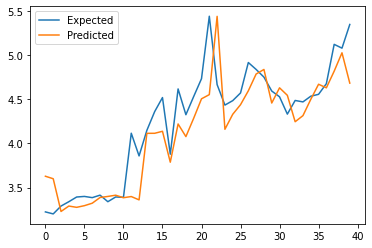

In [28]:
values=gst_merge_data[['rsi', 'rs', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

MAE: 0.296


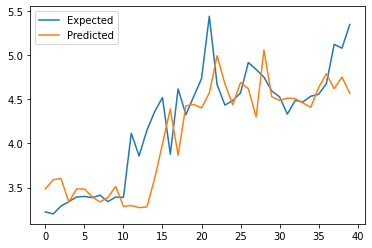

In [29]:
values=gst_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# GMT

MAE: 0.290


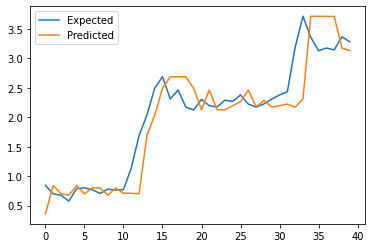

In [30]:
values=GMT[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [31]:
gmt_merge_data = pd.DataFrame({ 
                            'open': GMT['open'],
                            'rsi': GMT['rsi'],
                            'rs': GMT['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': GMT['adj close']
                          })

MAE: 0.279


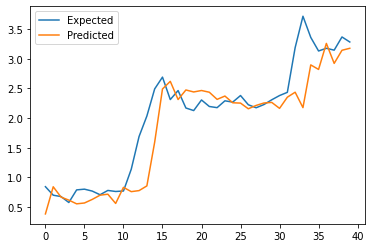

In [32]:
values=gmt_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)